In [30]:
#pip install sklearn
import pandas as pd
import numpy as np

# 繪圖相關套件
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use('ggplot') 

# 標籤編碼(Label)、獨熱編碼(OneHot)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
# 決策樹(Decision Tree)
from sklearn.tree import DecisionTreeClassifier
# 隨機森林(Random Forest)
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display

In [31]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submit = pd.read_csv('gender_submission.csv')

print( f'train {df_train.shape}' )
display( df_train.head() )

print( f'\ntest {df_test.shape}' )
display( df_test.head() )

train (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



test (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [32]:
# 定義判別欄位型態的函數
def Col_Types( Data ):
    Column_Types = Data.dtypes.to_frame().reset_index()   # 判別每個欄位的型態 
    Column_Types.columns = ['ColumnName','Type']
    Column_Types.sort_values( by='Type', inplace=True ) 
    return Column_Types

In [33]:
display( Col_Types(df_train) )

,ColumnName,Type
0,PassengerId,int64
1,Survived,int64
2,Pclass,int64
6,SibSp,int64
7,Parch,int64
5,Age,float64
9,Fare,float64
3,Name,object
4,Sex,object
8,Ticket,object


In [34]:
# 定義用來統計欄位缺漏值總數的函數
def Missing_Counts( Data ) : 
    missing = Data.isnull().sum()  # 計算欄位中缺漏值的數量 
    missing = missing[ missing>0 ]
    missing.sort_values( inplace=True ) 
    
    Missing_Count = pd.DataFrame( { 'ColumnName':missing.index, 'MissingCount':missing.values } )  # Convert Series to DataFrame
    Missing_Count[ 'Percentage(%)' ] = Missing_Count['MissingCount'].apply( lambda x:round(x/Data.shape[0]*100,2) )
    return  Missing_Count

In [35]:
print( 'train :' )
display( Missing_Counts(df_train) )

print( 'test :' )
display( Missing_Counts(df_test) )

train :


,ColumnName,MissingCount,Percentage(%)
0,Embarked,2,0.22
1,Age,177,19.87
2,Cabin,687,77.10


test :


,ColumnName,MissingCount,Percentage(%)
0,Fare,1,0.24
1,Age,86,20.57
2,Cabin,327,78.23


In [36]:
print( 'train' )
display( df_train.describe() )

print( 'test' )
display( df_test.describe() )

train


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


test


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [37]:
# 合併train及test的資料 
# df_data = df_train.append( df_test )
df_data = pd.concat([df_train, df_test])
df_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [38]:
Survived_Counts = df_data['Survived'].value_counts().reset_index()
Survived_Counts.columns = ['Survived','Counts']
Survived_Counts

,Survived,Counts
0,0.0,549
1,1.0,342


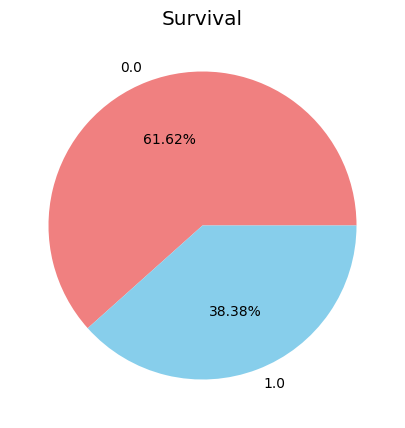

In [39]:
plt.figure( figsize=(10,5) )
df_data['Survived'].value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'Survival' )  # 圖標題
plt.ylabel( '' )
plt.show()

In [40]:
# # Survied 與其他欄位間的相關係數
# Corr_Matrix = df_train.corr()  # 計算相關係數
# Corr = Corr_Matrix.loc['Survived',:].sort_values()[:-1]
# Corr = pd.DataFrame({ 'Survived':Corr })
# Corr

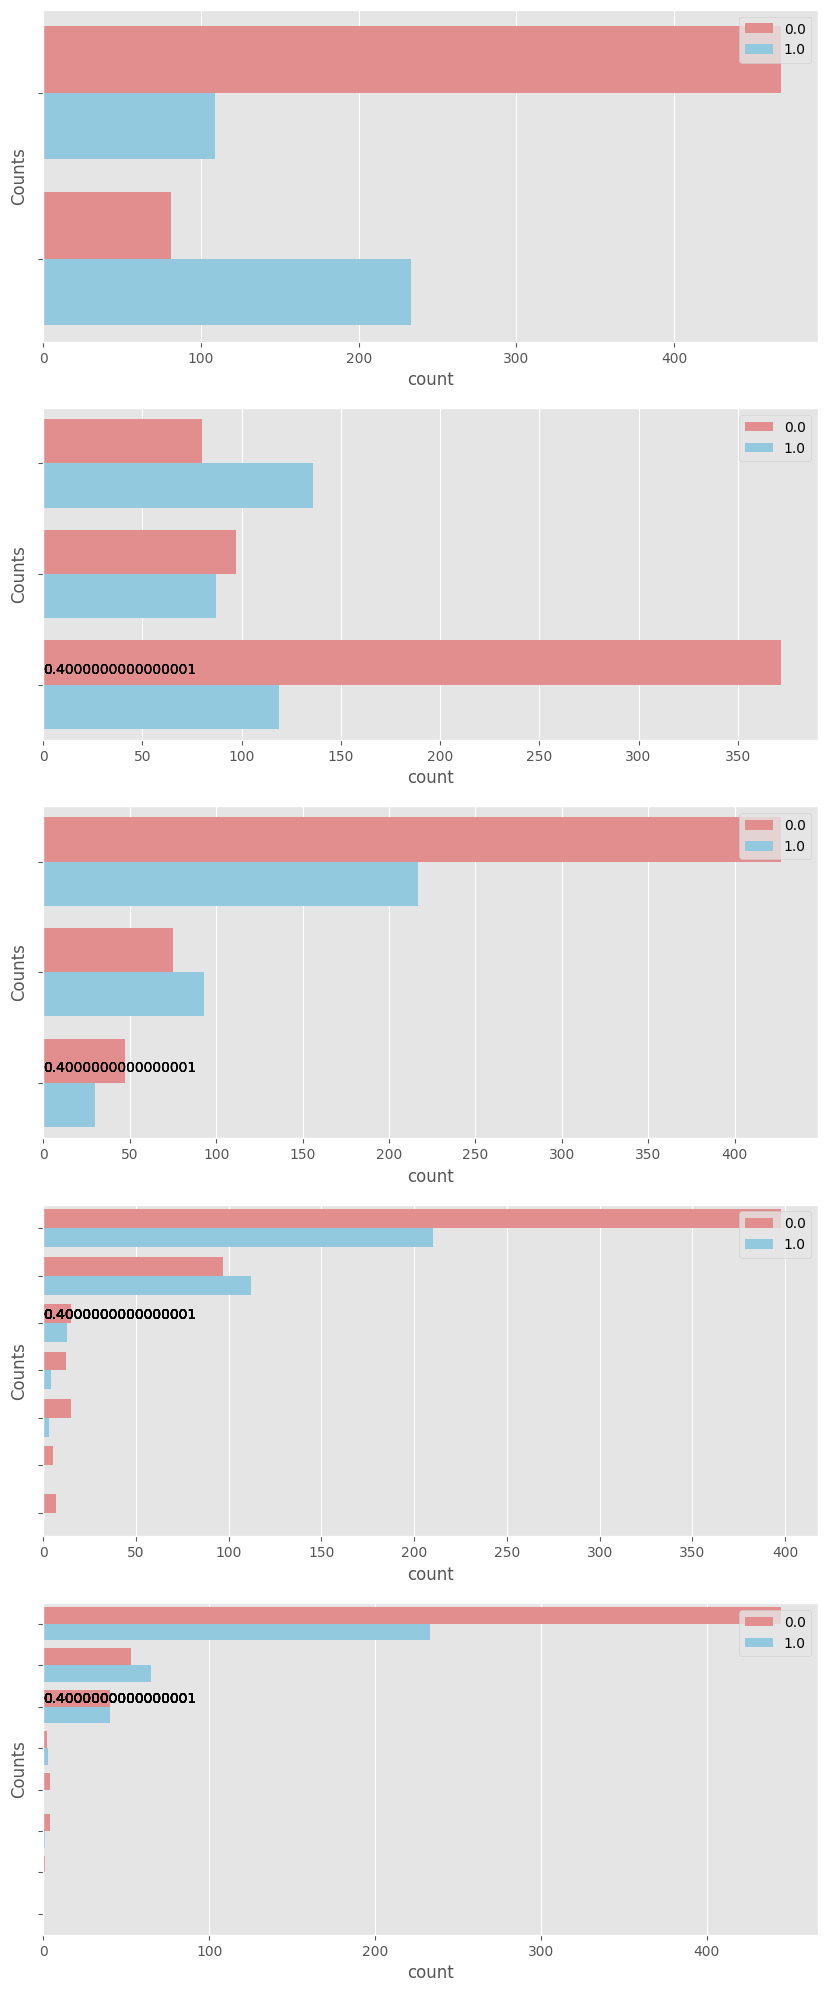

In [41]:
# Sex性別、Pclass票務艙、Embarked登船港口、SibSp兄弟姊妹配偶人數、Parch父母子女人數
selected_cols = ['Sex','Pclass','Embarked','SibSp','Parch']

plt.figure( figsize=(10,len(selected_cols)*5) )
gs = gridspec.GridSpec(len(selected_cols),1)    
for i, col in enumerate( df_data[selected_cols] ) :        
    ax = plt.subplot( gs[i] )
    sns.countplot( y=df_data[col], hue=df_data.Survived, palette=['lightcoral','skyblue'] )
    ax.set_yticklabels([])
    ax.set_ylabel( 'Counts' )
    ax.legend( loc=1 )   # upper right:1 ; upper left:2
    for p in ax.patches:
        ax.annotate( '{:,}'.format(p.get_height()), (p.get_x(), p.get_height()+1.5) )
plt.show()

In [42]:
for col in selected_cols:
    l = ['Survived']
    l.append(col) 
    Survival_Rate = df_data[l].groupby(by=col).mean().round(4).reset_index()
    Survival_Rate.columns = [col,'Survival Rate(%)']
    Survival_Rate['Survival Rate(%)'] = Survival_Rate['Survival Rate(%)'].map( lambda x:x*100 )
    display( Survival_Rate )    

,Sex,Survival Rate(%)
0,female,74.20
1,male,18.89


,Pclass,Survival Rate(%)
0,1,62.96
1,2,47.28
2,3,24.24


,Embarked,Survival Rate(%)
0,C,55.36
1,Q,38.96
2,S,33.70


,SibSp,Survival Rate(%)
0,0,34.54
1,1,53.59
2,2,46.43
3,3,25.00
4,4,16.67
5,5,0.00
6,8,0.00


,Parch,Survival Rate(%)
0,0,34.37
1,1,55.08
2,2,50.00
3,3,60.00
4,4,0.00
5,5,20.00
6,6,0.00
7,9,NaN


In [43]:
# 創造新的特徵變數：家庭人數(Family_Size)
df_data['Family_Size'] = df_data['SibSp'] + df_data['Parch'] + 1

Survival_Rate = df_data[['Family_Size','Survived']].groupby(by=['Family_Size']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

,Family_Size,Survival Rate(%)
0,1,30.353818
1,2,55.279503
2,3,57.843137
3,4,72.413793
4,5,20.000000
5,6,13.636364
6,7,33.333333
7,8,0.000000
8,11,0.000000


In [44]:
df_data[ 'Family_Class' ] = np.nan

df_data.loc[ df_data.Family_Size==0, 'Family_Class' ] = 2
df_data.loc[ (df_data.Family_Size>=1) & (df_data.Family_Size<=3), 'Family_Class' ] = 3
df_data.loc[ (df_data.Family_Size>=4) & (df_data.Family_Size<=6), 'Family_Class' ] = 2
df_data.loc[ (df_data.Family_Size>=7), 'Family_Class' ] = 1

In [45]:
# Sex & Pclass 
Survival_Rate = df_data[['Sex','Pclass','Survived']].groupby(by=['Sex','Pclass']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

,Sex,Pclass,Survival Rate(%)
0,female,1,96.808511
1,female,2,92.105263
2,female,3,50.000000
3,male,1,36.885246
4,male,2,15.740741
5,male,3,13.544669


In [46]:
df_data[ 'Sex_Pclass' ] = np.nan
df_data.loc[ (df_data.Sex=='female') & (df_data.Pclass==1), 'Sex_Pclass' ] = 2
df_data.loc[ (df_data.Sex=='female') & (df_data.Pclass==2), 'Sex_Pclass' ] = 3
df_data.loc[ (df_data.Sex=='female') & (df_data.Pclass==3), 'Sex_Pclass' ] = 3
df_data.loc[ (df_data.Sex=='male') & (df_data.Pclass==1), 'Sex_Pclass' ] = 1
df_data.loc[ (df_data.Sex=='male') & (df_data.Pclass==2), 'Sex_Pclass' ] = 1
df_data.loc[ (df_data.Sex=='male') & (df_data.Pclass==3), 'Sex_Pclass' ] = 2

In [47]:
# Method 1: split()
df_data['Title'] = df_data.Name.str.split(', ', expand=True)[1]
df_data['Title'] = df_data.Title.str.split('.', expand=True)[0]
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [48]:
# Method 2: 正規表示法(Regular Expression)
import re

regex = re.compile( ' ([A-Za-z]+)\.' )  
df_data['Title'] = df_data.Name.map( lambda x:regex.search(x)[0] )
# Dropping the first and the last words
df_data['Title'] = df_data.Title.map( lambda x:x[1:][:-1] )  
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [49]:
df_data['Title'] = df_data.Title.replace( ['Don','Rev','Dr','Major','Lady','Sir','Col','Capt','Countess','Jonkheer','Dona'], 'Rare' )
df_data['Title'] = df_data.Title.replace( ['Ms','Mlle'], 'Miss' )
df_data['Title'] = df_data.Title.replace( 'Mme', 'Mrs' )
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [50]:
# 刪除原始資料中的 Name 欄位 
df_data.drop( 'Name', axis=1, inplace=True )

In [51]:
df_data['Ticket_info'] = df_data.Ticket.apply( lambda x:x.replace('.','').replace('/','').strip().split(' ')[0] if not x.isdigit() else 'X')
df_data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [52]:
# 刪除原始資料中的 Ticket 欄位 
df_data.drop( 'Ticket', axis=1, inplace=True )

In [53]:
Missing_Counts( df_data.drop('Survived', axis=1) )

,ColumnName,MissingCount,Percentage(%)
0,Fare,1,0.08
1,Embarked,2,0.15
2,Age,263,20.09
3,Cabin,1014,77.46


In [54]:
df_data['Fare'].fillna( df_data.Fare.median(), inplace=True )

In [55]:
# 計算 Embarked 欄位中每個相異值的次數
display( df_data['Embarked'].value_counts() )
# 填補 Embarked 欄位的缺漏值
df_data['Embarked'].fillna( 'S', inplace=True )

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64

Sex,female,male,All
isAge,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


Pclass,1,2,3,All
isAge,,,,
0,39,16,208,263
1,284,261,501,1046
All,323,277,709,1309


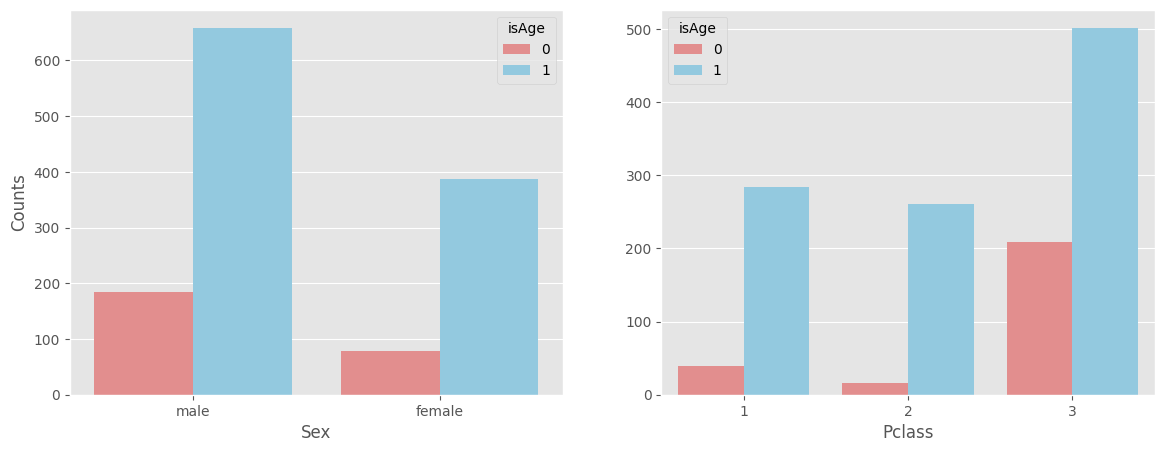

In [56]:
# 新增標註 Age 欄位是否為缺漏值的欄位(有缺漏標為0)
df_data['isAge'] = df_data['Age'].isnull().map( lambda x:0 if x==True else 1 )
# 分別觀察 Age 與 Sex、Pclass 的缺漏值分布狀況
display( pd.crosstab( df_data.isAge, df_data.Sex, margins=True ) )
display( pd.crosstab( df_data.isAge, df_data.Pclass, margins=True ) )

fig, axs = plt.subplots(1,2,figsize=(14,5))
#plt.suptitle('Age')

plt.subplot(1,2,1)
sns.countplot( x=df_data.Sex, hue=df_data.isAge, palette=['lightcoral','skyblue'] )
plt.ylabel( 'Counts' ) 

plt.subplot(1,2,2)
sns.countplot( x=df_data.Pclass, hue=df_data.isAge, palette=['lightcoral','skyblue'] )
plt.ylabel( '' ) 

plt.show() 

C:\Users\33\AppData\Local\Temp\ipykernel_10504\1866011444.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df_data.loc[index_S,'Age'], bins=20, color='blue', label='Survived' )
C:\Users\33\AppData\Local\Temp\ipykernel_10504\1866011444.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df_d

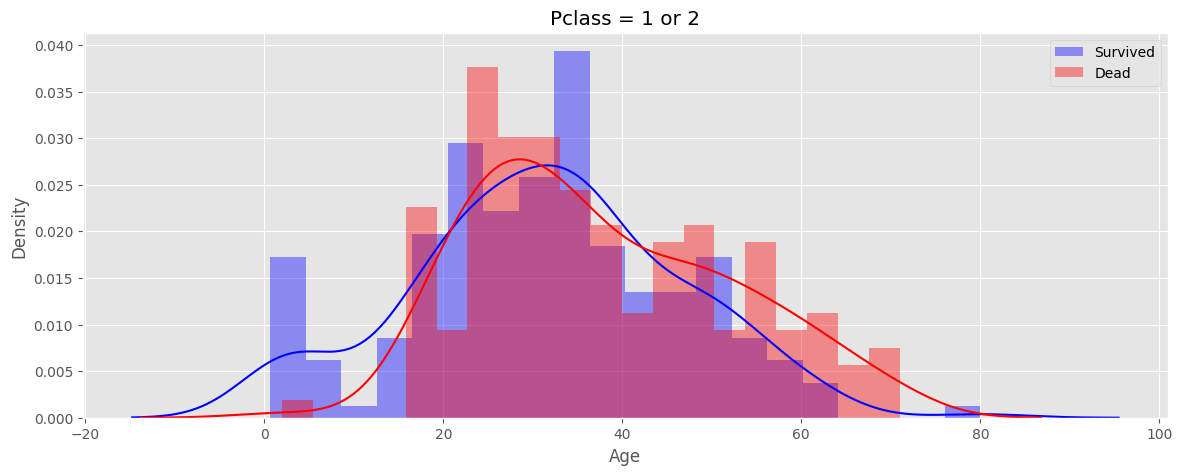

In [57]:
index_S = (df_data.isAge==1)&(df_data.Pclass!=3)&(df_data.Survived==1)
index_D = (df_data.isAge==1)&(df_data.Pclass!=3)&(df_data.Survived==0)

plt.figure( figsize=(14,5) )
sns.distplot( df_data.loc[index_S,'Age'], bins=20, color='blue', label='Survived' )
sns.distplot( df_data.loc[index_D,'Age'], bins=20, color='red', label='Dead' )
plt.title( 'Pclass = 1 or 2' )
plt.legend( )
plt.show( )

In [58]:
# 計算每個 Title 的年齡平均值及中位數
Age_Mean = df_data[['Title','Age']].groupby( by=['Title'] ).mean()
Age_Median = df_data[['Title','Age']].groupby( by=['Title'] ).median()

Age_Mean.columns = ['Age Mean']
Age_Median.columns = ['Age Median']
Age_Mean.reset_index( inplace=True )
Age_Median.reset_index( inplace=True )

display( Age_Median )
display( Age_Mean )

,Title,Age Median
0,Master,4.0
1,Miss,22.0
2,Mr,29.0
3,Mrs,35.0
4,Rare,47.5


,Title,Age Mean
0,Master,5.482642
1,Miss,21.824366
2,Mr,32.252151
3,Mrs,36.918129
4,Rare,45.178571


In [59]:
# 利用每個 Title 的年齡平均數，填補每個 Title 所對應 Age 的缺漏值
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Master'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Master','Age Mean'][0]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Miss'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Miss','Age Mean'][1]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Mr'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mr','Age Mean'][2]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Mrs'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mrs','Age Mean'][3]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Rare'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Rare','Age Mean'][4]

# 刪除 isAge 欄位 
df_data.drop( 'isAge', axis=1, inplace=True )

In [60]:
# 乘客年齡是否未滿17歲(是：1；否：0)
df_data[ 'is_Age_17' ] = (df_data.Age<17)*1
df_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_Size,Family_Class,Sex_Pclass,Title,Ticket_info,is_Age_17
0,1,0.0,3,male,22.000000,1,0,7.2500,NaN,S,2,3.0,2.0,Mr,A5,0
1,2,1.0,1,female,38.000000,1,0,71.2833,C85,C,2,3.0,2.0,Mrs,PC,0
2,3,1.0,3,female,26.000000,0,0,7.9250,NaN,S,1,3.0,3.0,Miss,STONO2,0
3,4,1.0,1,female,35.000000,1,0,53.1000,C123,S,2,3.0,2.0,Mrs,X,0
4,5,0.0,3,male,35.000000,0,0,8.0500,NaN,S,1,3.0,2.0,Mr,X,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,male,32.252151,0,0,8.0500,NaN,S,1,3.0,2.0,Mr,A5,0
414,1306,NaN,1,female,39.000000,0,0,108.9000,C105,C,1,3.0,2.0,Rare,PC,0
415,1307,NaN,3,male,38.500000,0,0,7.2500,NaN,S,1,3.0,2.0,Mr,SOTONOQ,0
416,1308,NaN,3,male,32.252151,0,0,8.0500,NaN,S,1,3.0,2.0,Mr,X,0


In [61]:
# 觀察 Cabin 中的種類
df_data['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [62]:
# 取出 Cabin 中的第一個字母，如果為缺漏值，則以 NoCabin 表示
df_data['Cabin'] = df_data['Cabin'].apply( lambda x:str(x)[0] if not pd.isnull(x) else 'NoCabin' )
df_data['Cabin'].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [63]:
Missing_Counts( df_data.drop('Survived', axis=1) )

,ColumnName,MissingCount,Percentage(%)


C:\Users\33\AppData\Local\Temp\ipykernel_10504\4284070221.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df_data.Fare, kde=True, bins=45, color='skyblue', label='bins = 45' )
C:\Users\33\AppData\Local\Temp\ipykernel_10504\4284070221.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df_

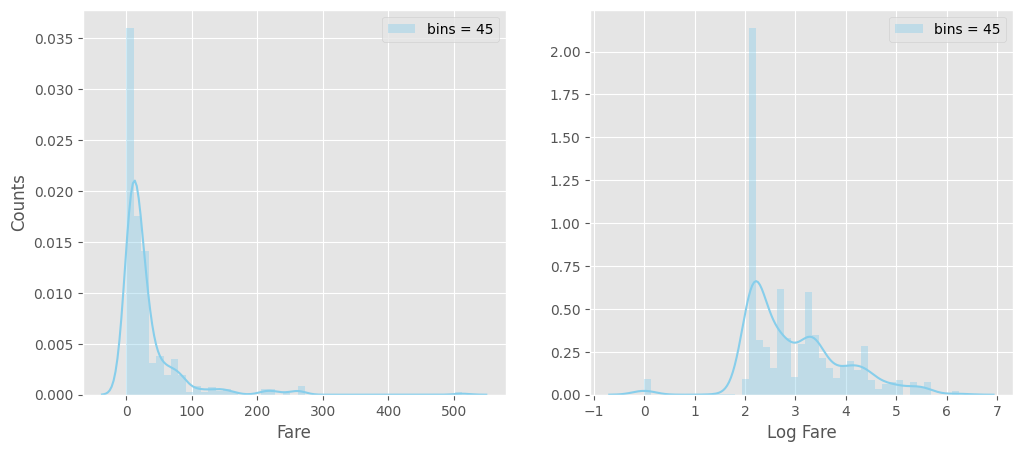

In [64]:
# 對 Fare 欄位取對數
df_data['LogFare'] = np.log1p( df_data.Fare )

# 直方圖(Histogram)
fig, axs = plt.subplots( 1,2,figsize=(12,5) )

plt.subplot( 1,2,1 )
sns.distplot( df_data.Fare, kde=True, bins=45, color='skyblue', label='bins = 45' )
plt.xlabel( 'Fare' ) 
plt.ylabel( 'Counts' ) 
plt.legend( )

plt.subplot( 1,2,2 )
sns.distplot( df_data.LogFare, kde=True, bins=45, color='skyblue', label='bins = 45' )
plt.xlabel( 'Log Fare' ) 
plt.ylabel( '' ) 
plt.legend( )

plt.show()

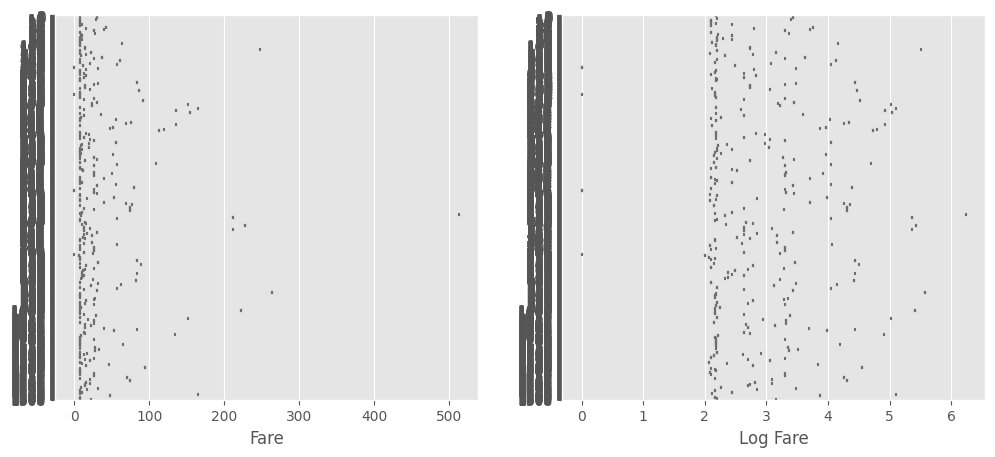

In [65]:
# 盒鬚圖(Box Plot)
fig, axs = plt.subplots( 1,2,figsize=(12,5) )

plt.subplot( 1,2,1 )
sns.boxplot( df_data.Fare, orient='h', color='skyblue' )
plt.xlabel( 'Fare' ) 

plt.subplot( 1,2,2 )
sns.boxplot( df_data.LogFare, orient='h', color='skyblue' )
plt.xlabel( 'Log Fare' ) 

plt.show()

In [66]:
# 計算 Fare 欄位各個百分位數(Percentile)
P_all = [ np.percentile( df_data.Fare, q=i ) for i in np.arange(0,101) ] 
Pth_Percentile = pd.DataFrame( { 'Q':list(range(101)), 'Value':P_all } )

# The first、second and third quartile(i,e., the 25th、50th and 75th Percentile)
Q1 = Pth_Percentile.iloc[ 25, 1 ]
Q2 = Pth_Percentile.iloc[ 50, 1 ]
Q3 = Pth_Percentile.iloc[ 75, 1 ]
IQR = Q3 - Q1

print( f'Q1 = {Q1}' )
print( f'Q2 = {Q2} = Median' )
print( f'Q3 = {Q3}' )
print( f'Maximum = {df_data.Fare.max()}')
print( f'IQR = Q3 - Q1 = {IQR}' )
print( f'Q3 + 1.5IQR = {Q3+1.5*IQR}' )

# 依照四分位數，對 Fare 欄位進行分組
Fare_bin = [ 0, Q1, Q2, Q3, Q3+1.5*IQR, df_data.Fare.max() ]
df_data[ 'Fare_Group' ] = pd.cut( df_data.Fare.values, Fare_bin )

# 計算每個分組中的資料筆數
Group_Counts = df_data[ 'Fare_Group' ].value_counts().reset_index()    
Group_Counts.columns = [ 'Fare_Group', 'Counts' ]
Group_Counts.sort_values( by='Fare_Group' )

Q1 = 7.8958
Q2 = 14.4542 = Median
Q3 = 31.275
Maximum = 512.3292
IQR = Q3 - Q1 = 23.379199999999997
Q3 + 1.5IQR = 66.34379999999999


,Fare_Group,Counts
2,"(0.0, 7.896]",320
1,"(7.896, 14.454]",321
0,"(14.454, 31.275]",328
4,"(31.275, 66.344]",152
3,"(66.344, 512.329]",171


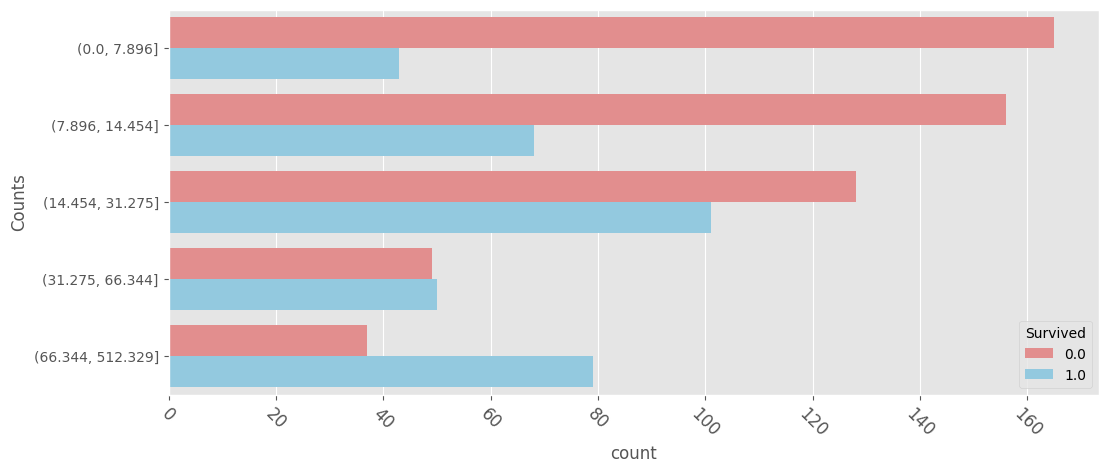

In [67]:
plt.subplots( figsize=(12,5) )
sns.countplot( y=df_data.Fare_Group, hue=df_data.Survived, palette=['lightcoral','skyblue'] )
plt.ylabel( 'Counts' ) 
plt.xticks( rotation=-45, fontsize=12 )
plt.show()

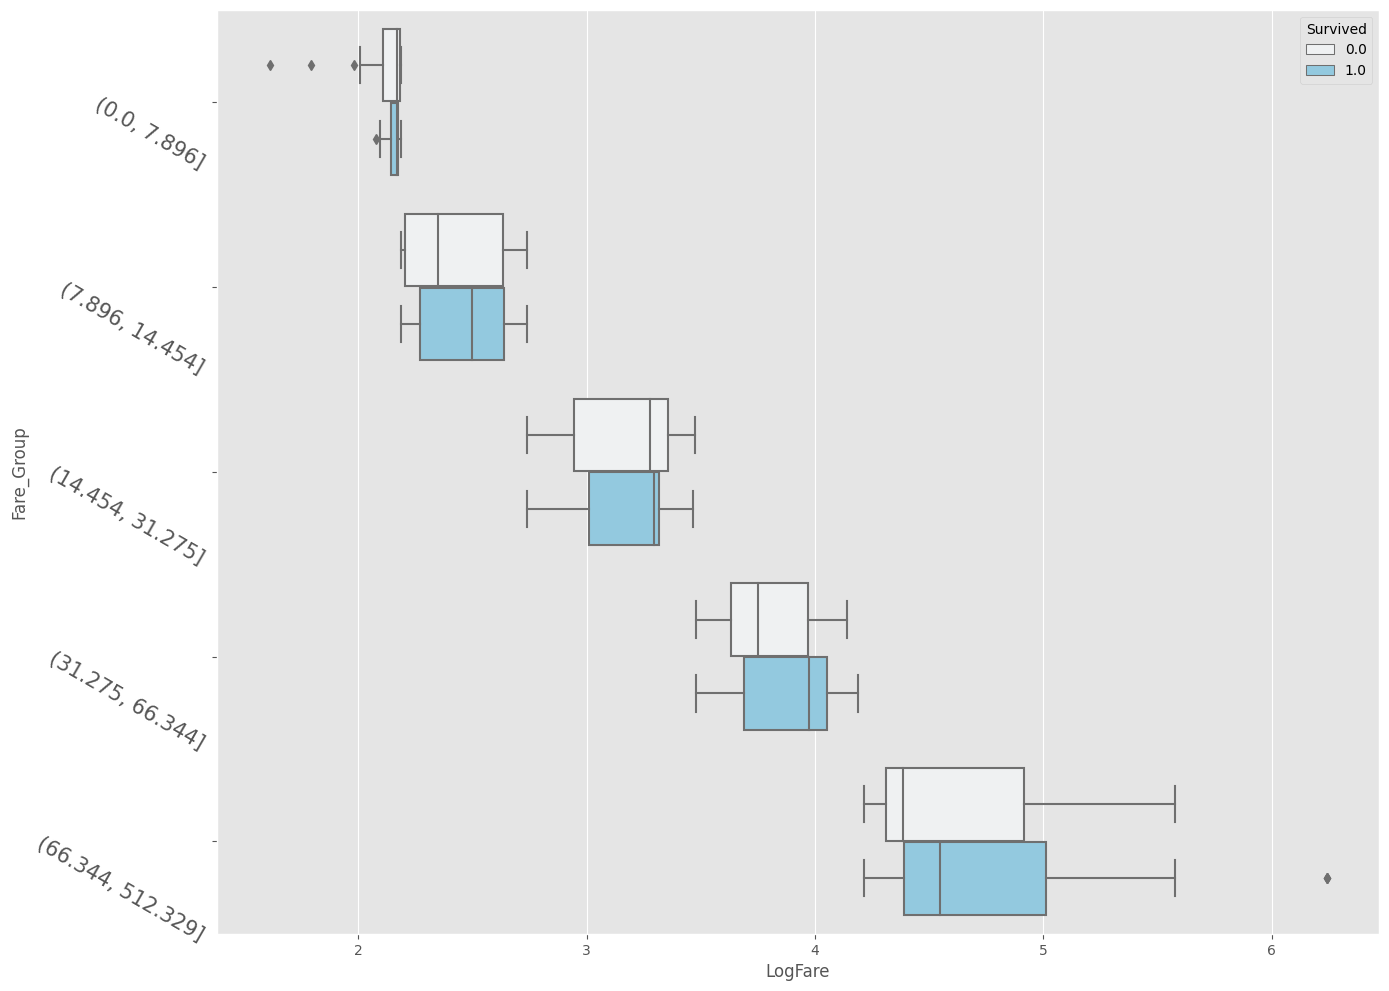

In [68]:
plt.subplots( figsize=(15,12) )
sns.boxplot( x='LogFare', y='Fare_Group', data=df_data, hue='Survived', orient='h', color='skyblue' )
plt.yticks( rotation=-30, fontsize=15 )
plt.show()

In [69]:
# 刪除 Fare_Group 欄位 
df_data.drop( ['Fare','Fare_Group'], axis=1, inplace=True )

In [70]:
# OneHot Encoding
OneHot_Embarked = pd.get_dummies( df_data.Embarked, prefix='Embarked' )

# 合併 Embarked 編碼後的欄位
df_data = pd.concat( [ df_data, OneHot_Embarked ], axis=1 )
df_data.drop( 'Embarked', axis=1, inplace=True )

In [71]:
# Label Encoding
Sex_mapping = { 'male':0, 'female':1 }
df_data[ 'Sex' ] = df_data.Sex.map( Sex_mapping )

In [72]:
# 檢視特徵工程後的資料
print( f'Shape of data after feature engineering = {df_data.shape}' )
df_data.head()

Shape of data after feature engineering = (1309, 18)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Family_Size,Family_Class,Sex_Pclass,Title,Ticket_info,is_Age_17,LogFare,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,0,22.0,1,0,NoCabin,2,3.0,2.0,Mr,A5,0,2.110213,False,False,True
1,2,1.0,1,1,38.0,1,0,C,2,3.0,2.0,Mrs,PC,0,4.280593,True,False,False
2,3,1.0,3,1,26.0,0,0,NoCabin,1,3.0,3.0,Miss,STONO2,0,2.188856,False,False,True
3,4,1.0,1,1,35.0,1,0,C,2,3.0,2.0,Mrs,X,0,3.990834,False,False,True
4,5,0.0,3,0,35.0,0,0,NoCabin,1,3.0,2.0,Mr,X,0,2.202765,False,False,True


In [73]:
for col in ['Title','Ticket_info','Cabin']:
    df_data[col] = df_data[col].astype('category').cat.codes

df_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Family_Size,Family_Class,Sex_Pclass,Title,Ticket_info,is_Age_17,LogFare,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,0,22.0,1,0,7,2,3.0,2.0,2,2,0,2.110213,False,False,True
1,2,1.0,1,1,38.0,1,0,2,2,3.0,2.0,3,14,0,4.280593,True,False,False
2,3,1.0,3,1,26.0,0,0,7,1,3.0,3.0,1,31,0,2.188856,False,False,True
3,4,1.0,1,1,35.0,1,0,2,2,3.0,2.0,3,36,0,3.990834,False,False,True
4,5,0.0,3,0,35.0,0,0,7,1,3.0,2.0,2,36,0,2.202765,False,False,True


In [74]:
# 產生訓練集和測試集
Train = df_data[ pd.notnull(df_data.Survived) ]
Test = df_data[ pd.isnull(df_data.Survived) ]

# 訓練集刪除 PassengerId 欄位；
# 測試集刪除 PassengerId 與 Survived 欄位
Train.drop( ['PassengerId'], axis=1, inplace=True )
Test.drop( ['PassengerId','Survived'], axis=1, inplace=True )

# 將測試集中的標籤欄位 Survived 單獨拆出
Y_Train = Train.Survived
X_Train = Train.drop( ['Survived'], axis=1 )

print( f'Shape of X_Train = {X_Train.shape}' )
print( f'Shape of Y_Train = {Y_Train.shape}' )
print( f'Shape of Test = {Test.shape}' )

Shape of X_Train = (891, 16)
Shape of Y_Train = (891,)
Shape of Test = (418, 16)


C:\Users\33\AppData\Local\Temp\ipykernel_10504\1973122403.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Train.drop( ['PassengerId'], axis=1, inplace=True )
C:\Users\33\AppData\Local\Temp\ipykernel_10504\1973122403.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test.drop( ['PassengerId','Survived'], axis=1, inplace=True )


In [75]:
# 建立決策樹模型
DTC = RandomForestClassifier( )
# 自變數、應變數進行擬合
DTC.fit( X_Train, Y_Train )

# 排序特徵重要性(由大到小)
col_names = X_Train.columns
importances = DTC.feature_importances_
Feature_Rank = pd.DataFrame( { 'Feature_Name':col_names, 'Importance':importances } )
Feature_Rank.sort_values( by='Importance', ascending=False, inplace=True ) 
Feature_Rank

,Feature_Name,Importance
12,LogFare,0.194829
2,Age,0.193510
1,Sex,0.148543
9,Title,0.084159
5,Cabin,0.065442
8,Sex_Pclass,0.064312
0,Pclass,0.058906
6,Family_Size,0.048736
10,Ticket_info,0.040847
3,SibSp,0.026218


In [76]:
# 隨機森林參數：
# n_estimators: 樹的數量(default=10)。
# min_samples_leaf: 最終葉節點最少樣本數(default=1)；
#                   當樣本不大時，可不設定使用預設，若樣本數量非常大時，則推薦增加此參數值。
# min_samples_split:節點再劃分時所需的最小樣本數(default=2)；
#                   當樣本不大時，可不設定使用預設，若樣本數量非常大時，則推薦增加此參數值。
# oob_score: 是否採用袋外樣本(out-of-bag samples)來評估模型的準確度(default=False)。

RFC = RandomForestClassifier( n_estimators = 1000,
                              min_samples_split = 20,
                              min_samples_leaf = 1,
                              oob_score = True,
                              random_state = 1,
                              n_jobs = -1 ) 

In [77]:
# 訓練模型
RFC.fit( X_Train, Y_Train )
print( 'oob_score = {:.6f}'.format(RFC.oob_score_) )

oob_score = 0.828283


In [78]:
RFC_2 = RandomForestClassifier( n_estimators = 1000,
                                min_samples_split = 20,
                                min_samples_leaf = 1,
                                oob_score = True,
                                random_state = 1,
                                n_jobs = -1 ) 

# 篩選部份特徵欄位餵入模型進行訓練
SelectedFeatures = ['Age','Sex','LogFare','Title','Pclass','Sex_Pclass']
RFC_2.fit( X_Train[SelectedFeatures], Y_Train )

print( f'Selected Features :\n   {SelectedFeatures}' )
print( 'oob_score = {:.6f}'.format(RFC_2.oob_score_) )

Selected Features :
   ['Age', 'Sex', 'LogFare', 'Title', 'Pclass', 'Sex_Pclass']
oob_score = 0.843996


In [79]:
# 預測測試集資料
Test_pred = RFC_2.predict( Test[SelectedFeatures] )

# 檢視預測罹難或生還的機率
#print( RFC_2.predict_proba(Test[SelectedFeatures]) )

# 提交檔案
submit['Survived'] = Test_pred.astype(int)
submit.to_csv( 'Titanic_RandomForest.csv', index=False )
print( f'預測結果：' )
submit 

預測結果：


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
